# Introduction to Applied Econometrics in Python
---

## Quick tip when using Jupyter notebooks
### Problem:
- Jupyter saves every object, class, and function in memory when you run each cell.
- First time users sometimes run a single cell over and over when debugging.
- This practice is problematic!
- If you are not careful, you could be running the same operation on a Dataframe multiple times!
- For example, imagine you had code in one cell to drop the first column of a three columned Dataframe `df = df.iloc[:,1:]`.
- If you ran this cell 3 times, you would end up deleting ALL the columns.
- These potentially unwanted manipulations of variables are called **side effects** in computer science.

### Solution:
- Unlike RStudio, Jupyter notebooks do not have a window showing all the global variables in memory!
- When in doubt, restart your kernel and rerun all cells in order.

In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

from stargazer.stargazer import Stargazer

# 1. Importing Data
---

In [2]:
# Import STATA dta file
democracy_data = pd.read_stata("data/democracy-balanced-l4.dta")
democracy_data

,country_name,wbcode,year,id,dem,lgdp
0,Angola,AGO,1987.0,3.0,0.0,6.730205
1,Angola,AGO,1988.0,3.0,0.0,6.760224
2,Angola,AGO,1989.0,3.0,0.0,6.738738
3,Angola,AGO,1990.0,3.0,0.0,6.708020
4,Angola,AGO,1991.0,3.0,0.0,6.665598
...,...,...,...,...,...,...
3376,Zimbabwe,ZWE,2005.0,202.0,0.0,5.893235
3377,Zimbabwe,ZWE,2006.0,202.0,0.0,5.861276
3378,Zimbabwe,ZWE,2007.0,202.0,0.0,5.827930
3379,Zimbabwe,ZWE,2008.0,202.0,0.0,5.635891


## 1.1. Check data types

In [3]:
democracy_data.dtypes

country_name     object
wbcode           object
year            float64
id              float64
dem             float64
lgdp            float32
dtype: object

### Comments:
- Common sense tells us that elements in `country_name` and `wbcode` should all be strings. 
- However, upon importing any form of data (e.g. csv, xls, dta), Pandas often considers columns that are potentially strings as the object dtype.
- An object datatype in a Pandas dataframe holds *any* Python object, including objects that *mix* strings and non-strings.
- The best practice for columns that should *only* contain strings is to convert them to StringDtype (see https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html#text-types for details)
- Moreover, we also observe that elements in `country_name` and `wbcode` should all be integers.

## 1.2. Convert data types

In [4]:
# Convert country_name and wbcode to StringDtype
for column in ["country_name", "wbcode"]:
    democracy_data[column] = democracy_data[column].astype("string")

# Convert year and id to Integers
for column in ["year", "id"]:
    democracy_data[column] = democracy_data[column].astype("int")

In [5]:
# Check dtypes again
democracy_data.dtypes

country_name     string
wbcode           string
year              int64
id                int64
dem             float64
lgdp            float32
dtype: object

## 1.3. Export cleaned data

### Problem:
- Often times you might want to seperate your data cleaning code with your data modelling code. Moreover, it is computationally expensive to have to run the data cleaning code everytime you terminate and reopen the Jupyter notebook.

### Solution:
- Export the dataframe into a file type that, as much as possible, *preserves the data types* when imported by Pandas in the future. This file type should also be quickly importable (Excel files are generally quite slow to be imported by Pandas).
- A common format used is the common seperated value (csv) file.
- "democracy-balanced-l4.csv" will be used in the Jupyter notebook "3_IV_and_panel_IV.ipynb".

In [6]:
# Export democracy_data into the data directory
democracy_data.to_csv("data/democracy-balanced-l4.csv")

## Key Lesson
---
- Some loss of meta-information, in particular data type information, is expected when sharing data across different programming languages, file types, and machines.
- It is your responsibility to ensure that the data types in your dataframe are accurate after *every* data import. 

### This exercise is important for three reasons:
1. Wrong data types lead to type errors when operating on your dataframe. (e.g. trying to add a column of strings with a column of integers)
2. Wrong data types can cause ***silent*** errors.
3. Wrong data types lead to ***inefficiencies***. Pandas has optimised operations specific to the dtype. 

In [7]:
# Consider the following dataframe
fail_early_example = pd.DataFrame([["10.5", "5.0"],["9.4", "5.1"], ["11", "5.2"]])
fail_early_example.columns = ["profit", "cost"]
fail_early_example

,profit,cost
0,10.5,5.0
1,9.4,5.1
2,11,5.2


In [8]:
# Create new column "revenue" 
fail_early_example["revenue"] = fail_early_example["profit"] + fail_early_example["cost"]
fail_early_example

,profit,cost,revenue
0,10.5,5.0,10.55.0
1,9.4,5.1,9.45.1
2,11,5.2,115.2


### Comments
- What went wrong?
- The two columns "profit" and "cost" that are inaccurately coded as strings. When we created a new column "revenue", the row with profit "10.5" and cost "5.0" will have revenue "10.55.0". 
- Python worked exactly as it should and intepreted the + operator between the profit and cost columns as string concatenation!
- Defend against silent errors ***as early as possible***.

References: 
https://blog.codinghorror.com/fail-early-fail-often/

# 2. Data Generation / Random Number Generation
---

In [9]:
# Let us define some variables to generate fake data
# Use global variables as sparingly as possible.
# We use a dictionary to hold our required variables.
# The official Python coding style guide (PEP 8) recommends  
# the capitalisation of all global variable names.

RANDOM_DATA_PARAMS = {
    "N": 3000,
    "beta_0": 2,
    "beta_1": 3,
    "sigma": 5,
    "transformation": lambda x: x + 5,  # This is a lambda function (see https://realpython.com/python-lambda/)
    "covariate_sd": 5}

SEED = 905

# The following is an example of a well-written function
# It contains a docstring.

def generate_reg_data(N, beta_0, beta_1, sigma, transformation, covariate_sd, seed=SEED):
    """Generates fake regression data with a list of three Pandas series.
    The regression model consists of the outcome, treatment, 
    a covariate variable, and a constant term.
    
    Arguments:
        - N (integer): sample size
        - beta_0 (integer): coefficient for the constant term
        - beta_1 (integer): coefficient for the treatment variable
        - sigma (integer): error term
        - transformation (function): a function that takes in the 
            treatment column, applies a transformation, then returns the mean values
            for the covariate columb
        - covariate_sd (integer): covariate's standard deviation
    
    Returns:
    A list of three Pandas series. The 1st element is the treatment.
    The 2nd element is the outcome. The 3rd element is the covariate.
    """
    np.random.seed(SEED)
    X = np.random.binomial(n=1, p=0.5, size=N)
    y = np.random.normal(beta_0 + beta_1*X, sigma, size=N)
    w =  np.random.normal(transformation(X), sigma, size=N)
    result = map(pd.Series, [y, X, w])
    return result

In [10]:
# Create a Dataframe from the tuple of Series objects returned from generate_reg_data
# The double asterisks unpack the dictionary RANDOM_DATA_PARAMS. The values in the dictionary
# RANDOM_DATA_PARAMS are mapped to the keyword arguments in the functiom generate_reg_data
# according to the corresponding keys in RANDOM_DATA_PARAMS.

fake_data_list = generate_reg_data(**RANDOM_DATA_PARAMS)   
fake_example_data = pd.concat(fake_data_list, axis=1, verify_integrity=True)

# Name the columns
fake_example_data.columns = ["profit", "treatment", "covariate"]
fake_example_data

,profit,treatment,covariate
0,6.560207,0,5.272208
1,12.680013,1,5.286069
2,-6.020173,1,10.718728
3,2.740736,0,13.765203
4,4.916705,1,-0.787469
...,...,...,...
2995,-5.732506,0,15.198484
2996,6.834820,1,1.473175
2997,-0.208997,0,6.642709
2998,5.525674,1,0.295714


## 2.1. Data Exploration

In [11]:
# Filter for untreated rows
fake_example_data_untreated = fake_example_data[fake_example_data["treatment"]==0]
fake_example_data_untreated

,profit,treatment,covariate
0,6.560207,0,5.272208
3,2.740736,0,13.765203
6,-1.721496,0,13.217349
7,10.880819,0,-7.374820
13,-0.074992,0,5.002852
...,...,...,...
2992,-2.734314,0,1.281339
2993,4.724001,0,-4.970439
2995,-5.732506,0,15.198484
2997,-0.208997,0,6.642709


In [12]:
# Compute summary statistics
fake_example_data.describe()

,profit,treatment,covariate
count,3000.000000,3000.000000,3000.000000
mean,3.432068,0.503333,5.384374
std,5.285950,0.500072,5.069415
min,-16.521360,0.000000,-12.857085
25%,-0.068202,0.000000,1.937722
50%,3.461068,1.000000,5.537484
75%,7.129640,1.000000,8.855968
max,24.451387,1.000000,21.037907


In [13]:
# Compute covariance matrix
fake_example_data.cov()

,profit,treatment,covariate
profit,27.941265,0.773401,0.810154
treatment,0.773401,0.250072,0.288194
covariate,0.810154,0.288194,25.698965


In [14]:
# You can compute the covariance matrix for a subset of columns
fake_example_data[["treatment","profit"]].cov()

,treatment,profit
treatment,0.250072,0.773401
profit,0.773401,27.941265


In [15]:
# Consider the following dataframe with missing values in every 4th row of the "treatment" column

# First let's create a new copy of the fake data:

fake_missing_data = fake_example_data # WRONG

# The above line only creates a reference (or "pointer" in CS-speak) to the original dataframe
# Any changes to fake_missing_data will modify the original fake_example_data dataframe.

fake_missing_data = fake_example_data.copy() # CORRECT

# Update every 4th row of the treatment column as a missing value
# NOTE! Some Pandas dataframe methods such as .iloc modify the dataframe inplace,
# whereas other methods such as .describe() returns a new object.

fake_missing_data.iloc[3::4, 0] = np.NaN
fake_missing_data

,profit,treatment,covariate
0,6.560207,0,5.272208
1,12.680013,1,5.286069
2,-6.020173,1,10.718728
3,NaN,0,13.765203
4,4.916705,1,-0.787469
...,...,...,...
2995,NaN,0,15.198484
2996,6.834820,1,1.473175
2997,-0.208997,0,6.642709
2998,5.525674,1,0.295714


In [16]:
# Remove all rows with missing values
fake_missing_data = fake_missing_data.dropna()
fake_missing_data

,profit,treatment,covariate
0,6.560207,0,5.272208
1,12.680013,1,5.286069
2,-6.020173,1,10.718728
4,4.916705,1,-0.787469
5,2.433593,1,11.939324
...,...,...,...
2993,4.724001,0,-4.970439
2994,10.341988,1,6.197986
2996,6.834820,1,1.473175
2997,-0.208997,0,6.642709


In [17]:
# Sometimes it might be useful to reset the index
# Don't forget set drop=True or the old index will be kept as a new column

fake_missing_data = fake_missing_data.reset_index(drop=True)
fake_missing_data

,profit,treatment,covariate
0,6.560207,0,5.272208
1,12.680013,1,5.286069
2,-6.020173,1,10.718728
3,4.916705,1,-0.787469
4,2.433593,1,11.939324
...,...,...,...
2245,4.724001,0,-4.970439
2246,10.341988,1,6.197986
2247,6.834820,1,1.473175
2248,-0.208997,0,6.642709


### Beware!
- There are a lot of subtleties to dealing with missing data.
- From the programmer's perspective, there could be different abstractions to implement a "missing data" type (https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html) 
- From the econometrician's perspective, removing rows with missing data could bias your results (e.g. the fact that some data is missing could be due to a selection effect correlated with potential outcomes).

# 3. Linear Regressions in Python statsmodels
---

- There are two APIs (Application Programming Interfaces) to running linear regressions in statsmodels.
- Statsmodels is a popular package for statistical modelling in Python.
- Both APIs are ***object orientated***:
1. You first instantiate some model class (e.g. OLS) by setting its required attributes.
2. You then call the model class's method that fits the data and compute the model's parameters. The fitted model's results are set inside the model instance.
3. Finally, you can access the results by calling the model class's method that returns a summary of the results.

- API 1. in step 1, you have to input **two seperate dataframes**: one with the endogenous variable and the other with the exogenous variables.
- API 2. in step 1, you have to input a R-styled **formula** that specifies the regression model fitted on some data in a dataframe.

References:
- https://www.statsmodels.org/stable/regression.html
- https://www.statsmodels.org/dev/examples/notebooks/generated/formulas.html

### My hot take:
- The two APIs generate the same results.
- Nevertheless, I prefer API 2. 
- To see why, let's compare the two APIs in the examples below.

### 3.1. Regress profit on treatment

In [18]:
# API 1.

mod = sm.OLS(endog=fake_example_data["profit"], exog = sm.add_constant(fake_example_data["treatment"]))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     280.7
Date:                Mon, 28 Sep 2020   Prob (F-statistic):           2.73e-60
Time:                        20:40:15   Log-Likelihood:                -9117.2
No. Observations:                3000   AIC:                         1.824e+04
Df Residuals:                    2998   BIC:                         1.825e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8754      0.131     14.319      0.000       1.619       2.132
treatment      3.0927      0.185     16.753      0.000       2.731       3.455
==============================================================================
Omnibus:                        3.659   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.161   Jarque-Bera (JB):                3.947
Skew:                           0.022   Prob(JB):                        0.139
Kurtosis:                       3.172   Cond. No.                         2.63
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
# API 2. Using R-styled formulas

mod = sm.formula.ols(formula='profit ~ treatment', data=fake_example_data)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     280.7
Date:                Mon, 28 Sep 2020   Prob (F-statistic):           2.73e-60
Time:                        20:40:15   Log-Likelihood:                -9117.2
No. Observations:                3000   AIC:                         1.824e+04
Df Residuals:                    2998   BIC:                         1.825e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8754      0.131     14.319      0.000       1.619       2.132
treatment      3.0927      0.185     16.753      0.000       2.731       3.455
==============================================================================
Omnibus:                        3.659   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.161   Jarque-Bera (JB):                3.947
Skew:                           0.022   Prob(JB):                        0.139
Kurtosis:                       3.172   Cond. No.                         2.63
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Side note:

In [20]:
# To run a regression without a constant term using API 2.
# Include a -1 term to the formula

mod = sm.formula.ols(formula='profit ~ treatment -1', data=fake_example_data)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 profit   R-squared (uncentered):                   0.313
Model:                            OLS   Adj. R-squared (uncentered):              0.313
Method:                 Least Squares   F-statistic:                              1365.
Date:                Mon, 28 Sep 2020   Prob (F-statistic):                   1.20e-246
Time:                        20:40:15   Log-Likelihood:                         -9216.5
No. Observations:                3000   AIC:                                  1.843e+04
Df Residuals:                    2999   BIC:                                  1.844e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
treatment      4.9681      0.134     36.951      0.000       4.704       5.232
==============================================================================
Omnibus:                        3.782   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.151   Jarque-Bera (JB):                3.975
Skew:                           0.040   Prob(JB):                        0.137
Kurtosis:                       3.159   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 3.2. Regress profit on treatment and covariate

In [21]:
# API 1.

mod = sm.OLS(endog=fake_example_data["profit"], exog = sm.add_constant(fake_example_data[["treatment", "covariate"]]))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     140.3
Date:                Mon, 28 Sep 2020   Prob (F-statistic):           5.66e-59
Time:                        20:40:15   Log-Likelihood:                -9117.2
No. Observations:                3000   AIC:                         1.824e+04
Df Residuals:                    2997   BIC:                         1.826e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8908      0.158     11.979      0.000       1.581       2.200
treatment      3.0964      0.186     16.662      0.000       2.732       3.461
covariate     -0.0032      0.018     -0.174      0.861      -0.039       0.033
==============================================================================
Omnibus:                        3.621   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.164   Jarque-Bera (JB):                3.902
Skew:                           0.022   Prob(JB):                        0.142
Kurtosis:                       3.171   Cond. No.                         17.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
# API 2. Using R-styled formulas

mod = sm.formula.ols(formula='profit ~ treatment + covariate', data=fake_example_data)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     140.3
Date:                Mon, 28 Sep 2020   Prob (F-statistic):           5.66e-59
Time:                        20:40:15   Log-Likelihood:                -9117.2
No. Observations:                3000   AIC:                         1.824e+04
Df Residuals:                    2997   BIC:                         1.826e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8908      0.158     11.979      0.000       1.581       2.200
treatment      3.0964      0.186     16.662      0.000       2.732       3.461
covariate     -0.0032      0.018     -0.174      0.861      -0.039       0.033
==============================================================================
Omnibus:                        3.621   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.164   Jarque-Bera (JB):                3.902
Skew:                           0.022   Prob(JB):                        0.142
Kurtosis:                       3.171   Cond. No.                         17.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 3.3. Interactions

In [23]:
# API 1. Part 1.

# Create a column for an interaction between treatment and the covariate

fake_interaction_data = fake_example_data.copy()
fake_interaction_data["treatment:covariate"] = fake_interaction_data["treatment"] * fake_interaction_data["covariate"]

fake_interaction_data

,profit,treatment,covariate,treatment:covariate
0,6.560207,0,5.272208,0.000000
1,12.680013,1,5.286069,5.286069
2,-6.020173,1,10.718728,10.718728
3,2.740736,0,13.765203,0.000000
4,4.916705,1,-0.787469,-0.787469
...,...,...,...,...
2995,-5.732506,0,15.198484,0.000000
2996,6.834820,1,1.473175,1.473175
2997,-0.208997,0,6.642709,0.000000
2998,5.525674,1,0.295714,0.295714


In [24]:
# API 1. Part 2.

mod = sm.OLS(endog=fake_interaction_data["profit"], 
        exog = sm.add_constant(fake_interaction_data[["treatment", "covariate", "treatment:covariate"]]))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     93.95
Date:                Mon, 28 Sep 2020   Prob (F-statistic):           4.14e-58
Time:                        20:40:15   Log-Likelihood:                -9116.6
No. Observations:                3000   AIC:                         1.824e+04
Df Residuals:                    2996   BIC:                         1.827e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.9889      0.181     10.977      0.000       1.634       2.344
treatment               2.8791      0.271     10.629      0.000       2.348       3.410
covariate              -0.0236      0.026     -0.906      0.365      -0.075       0.027
treatment:covariate     0.0404      0.037      1.103      0.270      -0.031       0.112
==============================================================================
Omnibus:                        3.640   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.162   Jarque-Bera (JB):                3.921
Skew:                           0.023   Prob(JB):                        0.141
Kurtosis:                       3.171   Cond. No.                         28.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
# API 2. Using R-styled formulas

# You can simply specify the interaction in the formula. 
# No need to explicitly modify / slice the original fake_example_data dataframe!
# See https://patsy.readthedocs.io/en/latest/categorical-coding.html

mod = sm.formula.ols(formula='profit ~ treatment*covariate', data=fake_example_data)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     93.95
Date:                Mon, 28 Sep 2020   Prob (F-statistic):           4.14e-58
Time:                        20:40:15   Log-Likelihood:                -9116.6
No. Observations:                3000   AIC:                         1.824e+04
Df Residuals:                    2996   BIC:                         1.827e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.9889      0.181     10.977      0.000       1.634       2.344
treatment               2.8791      0.271     10.629      0.000       2.348       3.410
covariate              -0.0236      0.026     -0.906      0.365      -0.075       0.027
treatment:covariate     0.0404      0.037      1.103      0.270      -0.031       0.112
==============================================================================
Omnibus:                        3.640   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.162   Jarque-Bera (JB):                3.921
Skew:                           0.023   Prob(JB):                        0.141
Kurtosis:                       3.171   Cond. No.                         28.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 3.4. Factor variables

In [26]:
# Create column of factors

factors = np.array(["good","bad","ugly"])
factors_data = np.repeat(factors, 
                    RANDOM_DATA_PARAMS["N"] / len(factors), axis=0)
factors_data = pd.Series(factors_data)
factors_data

0       good
1       good
2       good
3       good
4       good
        ... 
2995    ugly
2996    ugly
2997    ugly
2998    ugly
2999    ugly
Length: 3000, dtype: object

In [27]:
# Append column of factors to dataframe

fake_example_data["factor"] = factors_data
fake_example_data

,profit,treatment,covariate,factor
0,6.560207,0,5.272208,good
1,12.680013,1,5.286069,good
2,-6.020173,1,10.718728,good
3,2.740736,0,13.765203,good
4,4.916705,1,-0.787469,good
...,...,...,...,...
2995,-5.732506,0,15.198484,ugly
2996,6.834820,1,1.473175,ugly
2997,-0.208997,0,6.642709,ugly
2998,5.525674,1,0.295714,ugly


In [28]:
# API 1. Part 1.

# To use API 1, you have to create indicator variable (dummy) columns from the factor variable column.
# Creating and working with dummy variables in Pandas dataframes is messy.

dummies_data = pd.get_dummies(fake_example_data["factor"])
dummies_data

,bad,good,ugly
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
2995,0,0,1
2996,0,0,1
2997,0,0,1
2998,0,0,1


In [29]:
fake_factors_data = pd.concat([fake_example_data, dummies_data], axis=1)
fake_factors_data = fake_factors_data.drop("factor", axis=1)
fake_factors_data

,profit,treatment,covariate,bad,good,ugly
0,6.560207,0,5.272208,0,1,0
1,12.680013,1,5.286069,0,1,0
2,-6.020173,1,10.718728,0,1,0
3,2.740736,0,13.765203,0,1,0
4,4.916705,1,-0.787469,0,1,0
...,...,...,...,...,...,...
2995,-5.732506,0,15.198484,0,0,1
2996,6.834820,1,1.473175,0,0,1
2997,-0.208997,0,6.642709,0,0,1
2998,5.525674,1,0.295714,0,0,1


In [30]:
# API 1. Part 2.

mod = sm.OLS(endog=fake_example_data["profit"], exog = fake_factors_data.iloc[:,1:])
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     70.25
Date:                Mon, 28 Sep 2020   Prob (F-statistic):           6.12e-57
Time:                        20:40:15   Log-Likelihood:                -9116.9
No. Observations:                3000   AIC:                         1.824e+04
Df Residuals:                    2995   BIC:                         1.827e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
treatment      3.0913      0.186     16.618      0.000       2.727       3.456
covariate     -0.0034      0.018     -0.187      0.852      -0.039       0.033
bad            1.9862      0.208      9.540      0.000       1.578       2.394
good           1.8732      0.204      9.175      0.000       1.473       2.273
ugly           1.8244      0.203      9.004      0.000       1.427       2.222
==============================================================================
Omnibus:                        3.932   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.140   Jarque-Bera (JB):                4.283
Skew:                           0.022   Prob(JB):                        0.117
Kurtosis:                       3.180   Cond. No.                         23.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
# API 2. Using R-styled formulas

# You can simply code the categorical (or factor) variable in the formula. 
# No need to explicitly modify / slice the original fake_factors_data dataframe!
# See https://patsy.readthedocs.io/en/latest/categorical-coding.html

mod = sm.formula.ols(formula='profit ~ treatment + covariate + C(factor) - 1', data=fake_example_data)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     70.25
Date:                Mon, 28 Sep 2020   Prob (F-statistic):           6.12e-57
Time:                        20:40:15   Log-Likelihood:                -9116.9
No. Observations:                3000   AIC:                         1.824e+04
Df Residuals:                    2995   BIC:                         1.827e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
C(factor)[bad]      1.9862      0.208      9.540      0.000       1.578       2.394
C(factor)[good]     1.8732      0.204      9.175      0.000       1.473       2.273
C(factor)[ugly]     1.8244      0.203      9.004      0.000       1.427       2.222
treatment           3.0913      0.186     16.618      0.000       2.727       3.456
covariate          -0.0034      0.018     -0.187      0.852      -0.039       0.033
==============================================================================
Omnibus:                        3.932   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.140   Jarque-Bera (JB):                4.283
Skew:                           0.022   Prob(JB):                        0.117
Kurtosis:                       3.180   Cond. No.                         23.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 3.5. Saving text-like files

In [32]:
# Save regression results table in LaTeX into the media directory

with open("media/our_fancy_regression_table.tex", "w") as file:
    file.write(res.summary().as_latex())

# 4. Fancy Standard Errors in Python statsmodels
---

In [33]:
# Newey-West (1987) HAC standard errors

res_HAC = res.get_robustcov_results(cov_type="HAC", maxlags=0)
res_HAC.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 28 Sep 2020   Prob (F-statistic):                nan
Time:                        20:40:15   Log-Likelihood:                -9116.9
No. Observations:                3000   AIC:                         1.824e+04
Df Residuals:                    2995   BIC:                         1.827e+04
Df Model:                           4                                         
Covariance Type:                  HAC                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
C(factor)[bad]      1.9862      0.209      9.505      0.000       1.576       2.396
C(factor)[good]     1.8732      0.207      9.050      0.000       1.467       2.279
C(factor)[ugly]     1.8244      0.202      9.030      0.000       1.428       2.221
treatment           3.0913      0.186     16.599      0.000       2.726       3.456
covariate          -0.0034      0.018     -0.190      0.850      -0.039       0.032
==============================================================================
Omnibus:                        3.932   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.140   Jarque-Bera (JB):                4.283
Skew:                           0.022   Prob(JB):                        0.117
Kurtosis:                       3.180   Cond. No.                         23.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 0 lags and without small sample correction
"""

In [34]:
# White’s (1980) heteroskedasticity robust standard errors

res_EHW = res.get_robustcov_results(cov_type="HC0")
res_EHW.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 28 Sep 2020   Prob (F-statistic):                nan
Time:                        20:40:15   Log-Likelihood:                -9116.9
No. Observations:                3000   AIC:                         1.824e+04
Df Residuals:                    2995   BIC:                         1.827e+04
Df Model:                           4                                         
Covariance Type:                  HC0                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
C(factor)[bad]      1.9862      0.209      9.505      0.000       1.576       2.396
C(factor)[good]     1.8732      0.207      9.050      0.000       1.467       2.279
C(factor)[ugly]     1.8244      0.202      9.030      0.000       1.428       2.221
treatment           3.0913      0.186     16.599      0.000       2.726       3.456
covariate          -0.0034      0.018     -0.190      0.850      -0.039       0.032
==============================================================================
Omnibus:                        3.932   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.140   Jarque-Bera (JB):                4.283
Skew:                           0.022   Prob(JB):                        0.117
Kurtosis:                       3.180   Cond. No.                         23.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [35]:
# There is a Python implementation of R stargazer!
# However, stargazer takes in trained OLS models as its arguments

mod_HAC = sm.formula.ols(formula='profit ~ treatment + covariate + C(factor) - 1', data=fake_example_data)
res_HAC = mod_HAC.fit(cov_type="HAC", cov_kwds={"maxlags": 0})

mod_EHW = sm.formula.ols(formula='profit ~ treatment + covariate + C(factor) - 1', data=fake_example_data)
res_EHW = mod_EHW.fit(cov_type="HC0")

stargazer = Stargazer([res, res_HAC, res_EHW])
stargazer.custom_columns(["default","HAC","robust"], [1,1,1])
stargazer

In [36]:
# Save regression results table in LaTeX into the media directory

with open("media/our_stargazer_regression_table.tex", "w") as file:
    file.write(stargazer.render_latex())

# 5. Plotting in Python Pandas and seaborn
---

## Comments:
- Pandas Dataframes have methods that wrap around the matplotlib API to generate matplotlib plots.
- Seaborn is a data visualization library based on matplotlib. It provides a high-level API for drawing more inspired graphs than matplotlib.

References:
- https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html
- https://seaborn.pydata.org/examples/index.html

In [37]:
# Close any previously generated plots saved in memory
plt.close('all')

## 5.1. Pandas in-built plotting tools

<AxesSubplot:>

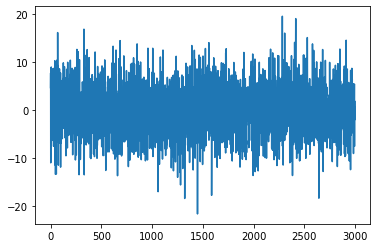

In [38]:
# Plot regression residuals

res_EHW.resid.plot()

<AxesSubplot:xlabel='treatment', ylabel='profit'>

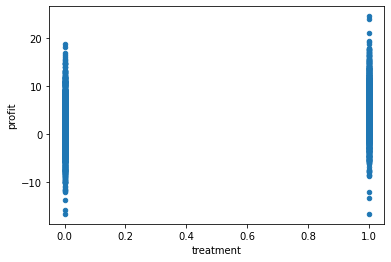

In [39]:
# Scatterplot of treatment and profit

fake_example_data.plot.scatter(x="treatment", y="profit")

## 5.2. Seaborn

In [40]:
# Set a Seaborn theme (see https://seaborn.pydata.org/tutorial/aesthetics.html)
# Set size of figures

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12,9)})

<AxesSubplot:xlabel='treatment', ylabel='profit'>

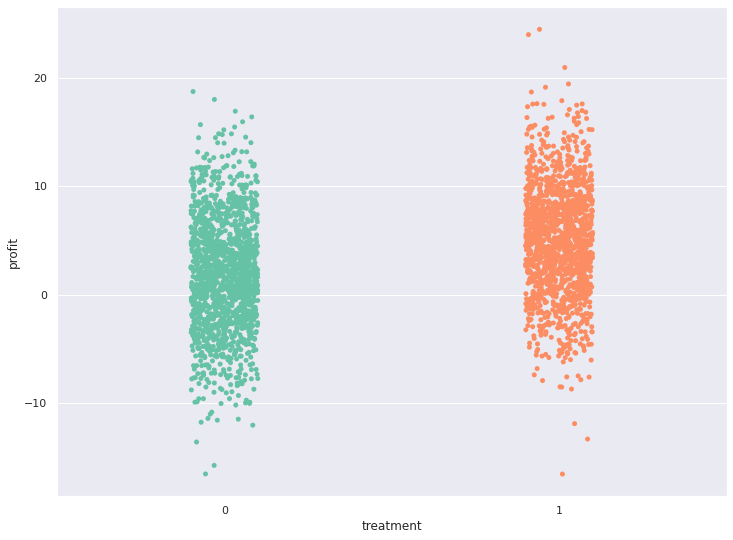

In [41]:
# Scatterplot with jitter where treatment is coded as a categorical variable and profit

jitter_plot = sns.stripplot(x="treatment", y="profit", data=fake_example_data, jitter=0.1, palette="Set2")
jitter_plot

<AxesSubplot:xlabel='treatment', ylabel='profit'>

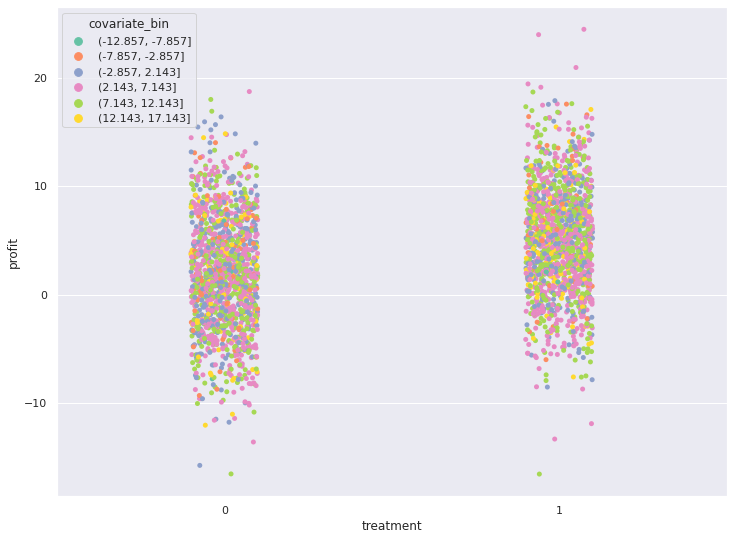

In [42]:
# Colour code observations by 5 unit ranges of the covariate

min_covariate = min(fake_example_data['covariate'])
max_covariate = max(fake_example_data['covariate'])
fake_example_data['covariate_bin'] = pd.cut(fake_example_data['covariate'], np.arange(min_covariate, max_covariate, step=5))

jitter_plot_with_covariate = sns.stripplot(x="treatment", y="profit", hue="covariate_bin",
                                            data=fake_example_data, jitter=0.1, palette="Set2")
jitter_plot_with_covariate

## Comments:
- Can we display all the Seaborn plots together?
- Yes!
- The seaborn methods above return matplotlib ***axes*** objects. Each axes corresponds to a single graph.
- You can group individual axes together into a ***figure***.
- These axes associated with a figure can be organised in different ways (e.g. placed side-by-side or even imposed on top of each other).

References:
- https://www.math.purdue.edu/~bradfor3/ProgrammingFundamentals/matplotlib/#canvases-figures-and-axes

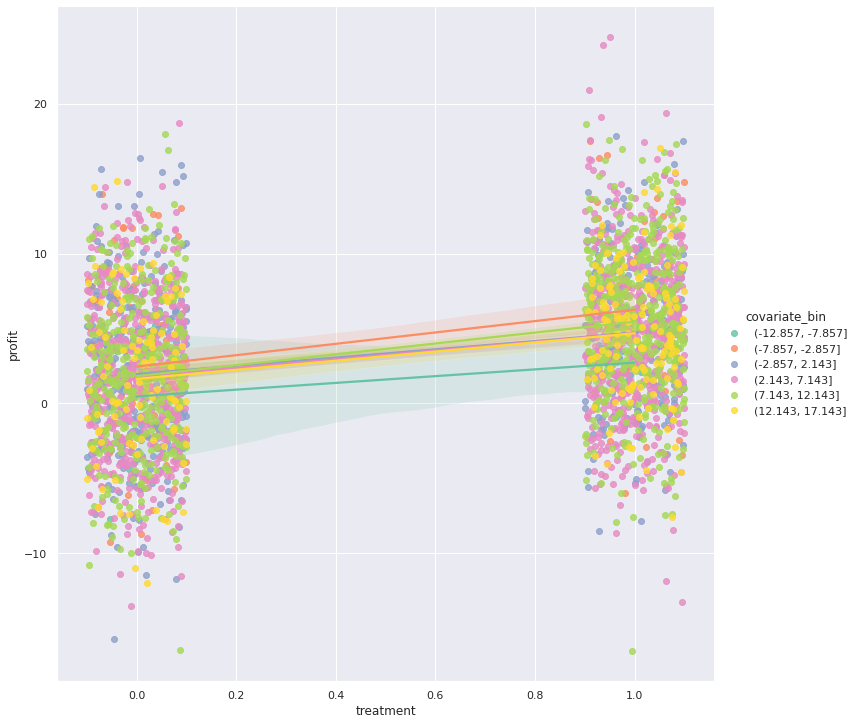

In [43]:
# Regression plot with lines stratified by covariate bins
# This plot is actually a figure!
# It is two axes, a regression plot and a scatterplot, imposed on top of each other.

reg_plot = sns.lmplot(x="treatment", y="profit", hue="covariate_bin",
                        data=fake_example_data, x_jitter=0.1, palette="Set2", height=10)

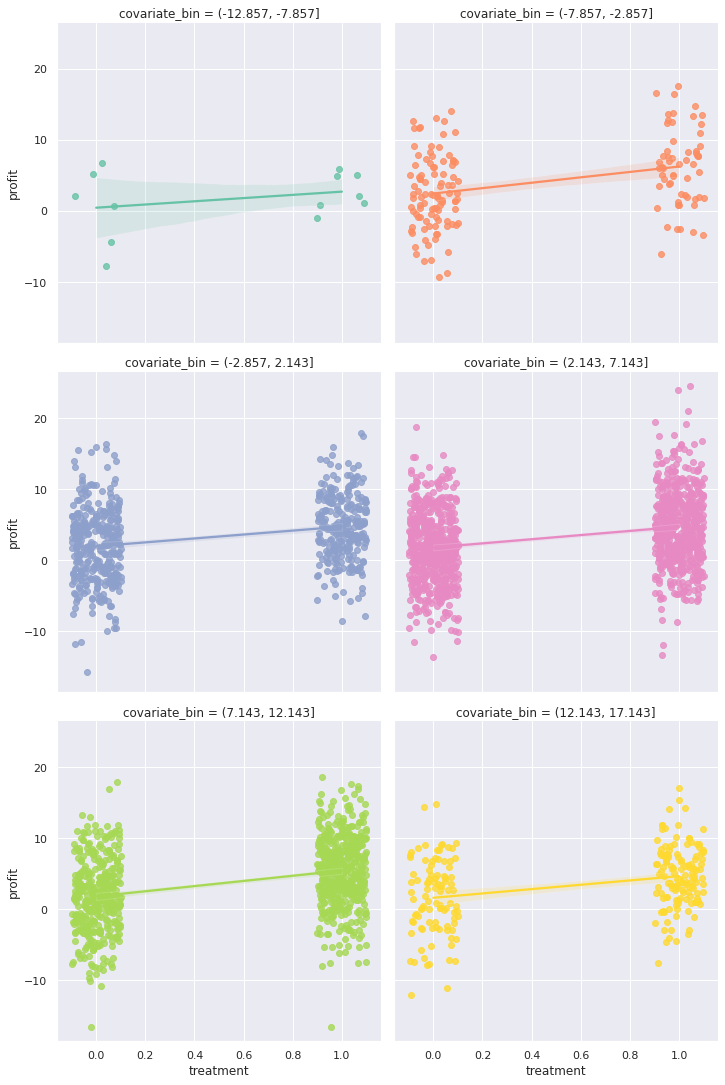

In [44]:
# Let's seperate out the regressions in the above graph

reg_subplots = sns.lmplot(x="treatment", y="profit", hue="covariate_bin", col="covariate_bin",
                            data=fake_example_data, x_jitter=0.1, col_wrap=2, palette="Set2")

## 5.3. Saving seaborn plots

In [45]:
# Save regression subplots as pdf into the media directory

reg_subplots.savefig("media/fancy_reg_subplots.pdf")

# 6. Python data science resources
---
- https://pandas.pydata.org/pandas-docs/stable/getting_started/comparison/comparison_with_sql.html
- https://seaborn.pydata.org/
- https://datascience.quantecon.org/